**In this notebook:** 
    
    - we estimate the age-stratified contact matrix
    - we estimate the intermediate contact matrix, stratified by SEP and SES on the participants' side
    - we correct both matrices for reciprocity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import cm
import math
import random

import geopandas as gp 
from shapely.geometry import Point, LineString

import datetime as dt

import time

import scipy.stats as st

import seaborn as sns

# read population data

In [2]:
data_pop_grouped = pd.read_csv("./../data/pop_size_by_age_SEP_edu.csv", index_col=0)

In [3]:
dict_pop_full = dict(zip(data_pop_grouped[['age_group', 
                           'sep_level', 'edu_level']].apply(lambda x: 
                                               x[0]+", "+x[1]+", "+x[2], axis=1).values, 
                   data_pop_grouped['population']))

dict_pop_full

{'0-14, high SEP, high edu': 0.0,
 '0-14, low SEP, high edu': 0.0,
 '0-14, high SEP, low edu': 910215.0,
 '0-14, low SEP, low edu': 413202.0,
 '15-24, high SEP, high edu': 51812.0,
 '15-24, low SEP, high edu': 24823.0,
 '15-24, high SEP, low edu': 552631.0,
 '15-24, low SEP, low edu': 264751.0,
 '25-64, high SEP, high edu': 1687317.3094791055,
 '25-64, low SEP, high edu': 536759.268093747,
 '25-64, high SEP, low edu': 1727216.6905208929,
 '25-64, low SEP, low edu': 938743.7319062528,
 '65+, high SEP, high edu': 349133.05628178443,
 '65+, low SEP, high edu': 111064.1150329906,
 '65+, high SEP, low edu': 799172.9437182155,
 '65+, low SEP, low edu': 427282.8849670094}

In [4]:
pop_age = data_pop_grouped.groupby('age_group')['population'].sum()
pop_age = dict(zip(pop_age.index, pop_age.values))
pop_age

{'0-14': 1323417.0,
 '15-24': 894017.0,
 '25-64': 4890036.999999998,
 '65+': 1686653.0}

In [5]:
distrib_pop = data_pop_grouped.groupby('age_group')['population'].sum()/data_pop_grouped['population'].sum()
distrib_pop = dict(zip(distrib_pop.index, distrib_pop.values))
distrib_pop

{'0-14': 0.1504887809178038,
 '15-24': 0.10166072254610012,
 '25-64': 0.5560573173632757,
 '65+': 0.19179317917282043}

# read participant data

In [7]:
comix = pd.read_csv("./../data/processed/comixdata_part_cleaned+sep_munic+cont_overall.csv")

In [8]:
comix.drop('education_level3', axis=1, inplace=True)
comix['education_level3'] = comix['education_level3_v3']

In [9]:
comix['education_level3'].unique()

array(['Without tertiary education', 'Tertiary level'], dtype=object)

In [10]:
comix['sep3_quartile'].unique()

array(['highest', 'lowest'], dtype=object)

In [11]:
tag_edu = dict(zip(['Without tertiary education', 'Tertiary level'],
                     ['low edu', 'high edu']))

tag_sep = dict(zip(['lowest', 'highest'],
                     ['low SEP', 'high SEP']))

comix['education_level3'] = comix['education_level3'].apply(lambda x: tag_edu[x])
comix['sep3_quartile'] = comix['sep3_quartile'].apply(lambda x: tag_sep[x])

## assign age group 

In [12]:
comix.drop('age_part_3cat', axis=1, inplace=True)

In [13]:
comix['age_part_4cat'] = comix['age_group_part']

In [14]:
comix['age_part_4cat'].unique()

array(['15-24', '25-64', '65+', '0-14'], dtype=object)

# read contact data

In [15]:
#comix_cont = pd.read_csv("./../../0_github_ISPMBern_comix_new/output/comixdata_cont_cleaned.csv")
comix_cont = pd.read_csv("./../data/comixdata_cont_cleaned.csv")

comix_cont = comix_cont[comix_cont['panel_wave'].isin(['A1', 'B1', 'F1', 'C1', 'D1', 'E1'])].copy()

In [16]:
comix_cont['cnt_age'].unique()

array(['0-18', '18-65', '65+', '45-54', '55-64', '16-17', '70-74',
       '35-44', '5-11', '1-4', '12-15', '20-24', '75-79', '65-69',
       '25-34', '18-19', '0-1', '80-84', '85+', 'Don’t know',
       'Prefer not to answer', nan, '5-9', '15-19', '10-14'], dtype=object)

## assign age group of contacts

In [17]:
comix_cont = pd.merge(comix_cont, comix[['panel_wave_id', 'age_part_4cat']], 
                      on = 'panel_wave_id', how = "left")

In [18]:
comix_cont.groupby(['cnt_age']).size()

cnt_age
0-1                      185
0-18                    3922
1-4                      859
10-14                    371
12-15                    570
15-19                    258
16-17                    239
18-19                    203
18-65                   7019
20-24                    861
25-34                   2013
35-44                   2170
45-54                   1997
5-11                    1144
5-9                      517
55-64                   1477
65+                     3186
65-69                    550
70-74                    421
75-79                    260
80-84                    119
85+                       95
Don’t know               282
Prefer not to answer     100
dtype: int64

In [19]:
len(comix_cont[comix_cont['cnt_age'].isna()])

6254

In [20]:
(6254+282+100)/len(comix_cont)

0.18921076642335766

In [21]:
comix['age_part_4cat'].unique()

array(['15-24', '25-64', '65+', '0-14'], dtype=object)

In [22]:
random.random()

0.8927385334791497

In [23]:
sum(distrib_pop.values())

1.0

### compute distribution of contact age (for contacts with known age), for each participant age group

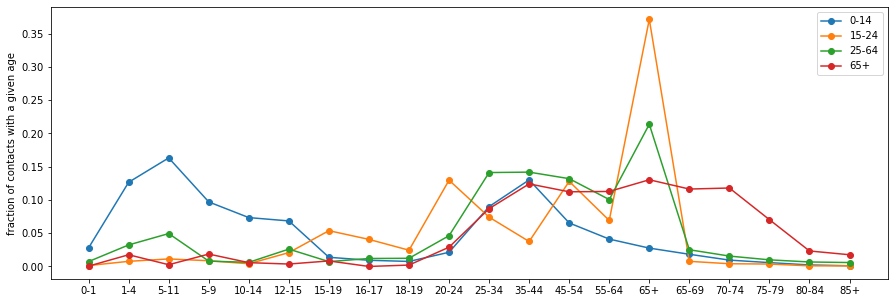

In [24]:
distrib_cont={}

for group in comix['age_part_4cat'].unique():
    # filter participants with a given age group
    part_filter = comix[comix['age_part_4cat']==group]['panel_wave_id'].values
    # filter contacts on participants with a given age group
    comix_cont_filter = comix_cont[comix_cont['panel_wave_id'].isin(part_filter)]
    # remove overlapping age groups
    comix_cont_filter = comix_cont_filter[comix_cont_filter['cnt_age'].isin(['0-18', '18-65', '25-64', 
                                                     'Don’t know', 'Prefer not to answer'])==False]
    # compute distribution of contacts (with known age) for this participant age group
    distrib_cont[group] = comix_cont_filter.groupby('cnt_age').size()
    
    if '16-17' not in distrib_cont[group].index:
        new_row = pd.Series([0], index=['16-17'])
        distrib_cont[group]  = pd.concat([distrib_cont[group] , new_row])
    
    distrib_cont[group] = distrib_cont[group].loc[['0-1', '1-4',  '5-11', '5-9', 
                                                   '10-14', '12-15', '15-19', '16-17', '18-19', 
                                                   '20-24', '25-34', '35-44', '45-54', '55-64', 
                                                   '65+', '65-69', '70-74', '75-79', '80-84', '85+']]

plt.figure(figsize=(15,5))
for group in ['0-14', '15-24', '25-64', '65+']:
    plt.plot(distrib_cont[group].index.values, 
             distrib_cont[group].values/distrib_cont[group].values.sum(), '-o', label=group)
plt.ylabel('fraction of contacts with a given age')
plt.legend()
plt.show()

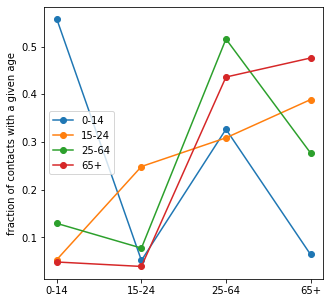

In [25]:
distrib_cont_4cat={}

for group in ['0-14', '15-24', '25-64', '65+']:
    distrib_cont_4cat[group] = {}
    
    distrib_cont_4cat[group]['0-14'] = distrib_cont[group].loc[['0-1', '1-4',  '5-11', 
                                                                '5-9', '10-14', '12-15']].sum()/distrib_cont[group].sum()
    
    distrib_cont_4cat[group]['15-24'] = distrib_cont[group].loc[['15-19', '16-17', 
                                                                 '18-19', '20-24']].sum()/distrib_cont[group].sum()
    
    distrib_cont_4cat[group]['25-64'] = distrib_cont[group].loc[['25-34', '35-44', 
                                                                 '45-54', '55-64']].sum()/distrib_cont[group].sum()
    
    distrib_cont_4cat[group]['65+'] = distrib_cont[group].loc[['65+', '65-69', '70-74', 
                                                               '75-79', '80-84', '85+']].sum()/distrib_cont[group].sum()

plt.figure(figsize=(5,5))
for group in ['0-14', '15-24', '25-64', '65+']:
    plt.plot(distrib_cont_4cat[group].keys(), 
             distrib_cont_4cat[group].values(), '-o',  label=group)
plt.ylabel('fraction of contacts with a given age')
plt.legend()
plt.show()

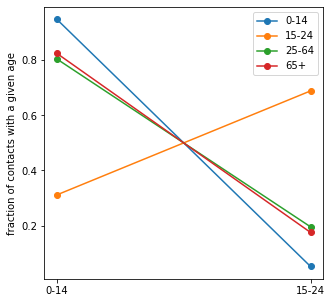

In [26]:
distrib_cont_0_18={}

for group in ['0-14', '15-24', '25-64', '65+']:
    distrib_cont_0_18[group] = {}
    
    tot = distrib_cont[group].loc[['0-1', '1-4',  '5-11', 
                                   '5-9', '10-14', '12-15',
                                  '15-19', '16-17', '18-19']].sum()
    
    distrib_cont_0_18[group]['0-14'] = distrib_cont[group].loc[['0-1', '1-4',  '5-11', 
                                                                '5-9', '10-14', '12-15']].sum()/tot
    
    distrib_cont_0_18[group]['15-24'] = distrib_cont[group].loc[['15-19', '16-17', '18-19']].sum()/tot
    
plt.figure(figsize=(5,5))
for group in ['0-14', '15-24', '25-64', '65+']:
    plt.plot(distrib_cont_0_18[group].keys(), 
             distrib_cont_0_18[group].values(), '-o', label=group)
plt.ylabel('fraction of contacts with a given age')
plt.legend()
plt.show()

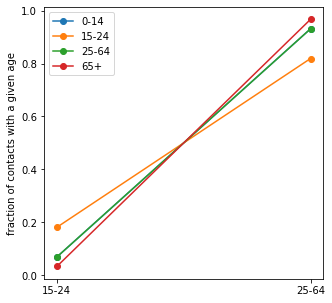

In [27]:
distrib_cont_18_65={}

for group in ['0-14', '15-24', '25-64', '65+']:
    distrib_cont_18_65[group] = {}
    
    tot = distrib_cont[group].loc[['18-19', '20-24', '25-34', '35-44', '45-54', '55-64', 
                                   '65+', '65-69', '70-74', '75-79', '80-84', '85+']].sum()
    
    distrib_cont_18_65[group]['15-24'] = distrib_cont[group].loc[['18-19', '20-24']].sum()/tot
    
    distrib_cont_18_65[group]['25-64'] = distrib_cont[group].loc[[ '25-34', '35-44', '45-54', '55-64', 
                                               '65+', '65-69', '70-74', '75-79', '80-84', '85+']].sum()/tot
    
plt.figure(figsize=(5,5))
for group in ['0-14', '15-24', '25-64', '65+']:
    plt.plot(distrib_cont_18_65[group].keys(), 
             distrib_cont_18_65[group].values(), '-o', label=group)
plt.ylabel('fraction of contacts with a given age')
plt.legend()
plt.show()

### apply the observed distribution

In [28]:
def assign_contact_age(age_part, age_cont):
    
    if age_cont in ['0-18']:
        p = random.random()
        if p < distrib_cont_0_18[age_part]['0-14']:
            y = '0-14'
        else:
            y = '15-24'   
            
    elif age_cont in ['18-65']:
        p = random.random()
        if p < distrib_cont_18_65[age_part]['15-24']:
            y = '15-24' 
        else:
            y = '25-64'
            
    elif age_cont in ['0-1', '1-4', '5-9', '5-11', '10-14', '12-15']:
        y = '0-14'
    elif age_cont in ['15-19', '16-17', '18-19', '20-24']: 
        y = '15-24'
    elif age_cont in ['25-34', '35-44', '45-54', '55-64']: 
        y ='25-64'
    elif age_cont in ['65+', '65-69', '70-74', '75-79', '80-84', '85+']:
        y = '65+'
    elif age_cont in ['Don’t know', 'Prefer not to answer', np.nan]: 

        p = random.random()     
        if p < distrib_cont_4cat[age_part]['0-14']:
            y = '0-14'
        elif p < distrib_cont_4cat[age_part]['0-14']+distrib_cont_4cat[age_part]['15-24']:
            y = '15-24'
        elif p < distrib_cont_4cat[age_part]['0-14']+distrib_cont_4cat[age_part]['15-24']+distrib_cont_4cat[age_part]['25-64']:
            y = '25-64'
        elif p <= 1:
            y = '65+'
        else:
            sys.exit()
    else:
        sys.exit()

    return y             

In [29]:
random.seed(42)

comix_cont['cnt_age_group_4cat'] = comix_cont[['age_part_4cat',
                                               'cnt_age']].apply(lambda x: assign_contact_age(x[0], x[1]), axis=1)

In [30]:
comix_cont['cnt_age_group_4cat'].unique()

array(['0-14', '15-24', '25-64', '65+'], dtype=object)

# age-stratified matrix

## compute number of contacts per participant, by age of contact

In [31]:
comix_cont_per_part = comix_cont.groupby(['panel_wave_id', 'cnt_age_group_4cat']).size().reset_index()
comix_cont_per_part

,panel_wave_id,cnt_age_group_4cat,0
0,A1_101561,0-14,1
1,A1_101561,15-24,1
2,A1_101561,25-64,4
3,A1_101561,65+,1
4,A1_101562,25-64,2
...,...,...,...
9133,F1_115487,65+,1
9134,F1_115488,25-64,2
9135,F1_115488,65+,1
9136,F1_115489,0-14,1


In [32]:
comix_cont_per_part.groupby('cnt_age_group_4cat')[0].sum()

cnt_age_group_4cat
0-14      8479
15-24     3456
25-64    16946
65+       6191
Name: 0, dtype: int64

In [33]:
comix_cont_per_part.groupby('cnt_age_group_4cat')[0].sum().sum()

35072

### add zeros

In [34]:
len(comix) - len(comix_cont_per_part['panel_wave_id'].unique())
### 485 participants declared 0 contacts

485

In [35]:
comix_cont_per_part['cnt_age_group_4cat'].unique()

array(['0-14', '15-24', '25-64', '65+'], dtype=object)

In [36]:
df = comix_cont_per_part.copy()

for part_id in comix['panel_wave_id'].unique():
    # for each participant
    for age in comix_cont_per_part['cnt_age_group_4cat'].unique():
        #for each age group
        if len(df[(df['panel_wave_id']==part_id) & (df['cnt_age_group_4cat']==age)])<1:
            row = pd.DataFrame({'panel_wave_id': part_id,
                                   'cnt_age_group_4cat': age,
                                       0: 0}, index=[0])
            df = pd.concat([df, row], ignore_index=True)

In [37]:
len(comix_cont_per_part), len(df)

(9138, 17848)

In [38]:
df.columns = ['panel_wave_id', 'cnt_age_group_4cat', 'contacts']

In [39]:
len(df)/4

4462.0

In [40]:
len(comix['panel_wave_id'].unique())

4462

In [41]:
len(comix)

4462

## merge with file on participants

In [42]:
comix.columns

Index(['part_id', 'panel_wave_id', 'date', 'panel_wave', 'age_part',
       'part_age_est_min', 'part_age_est_max', 'lower.age.limit', 'gender',
       'gender_responder', 'zip_code', 'name_munic', 'id_distr', 'name_distr',
       'region', 'canton', 'region_ch', 'grossregion', 'region_urban_rural',
       'occupation', 'employment', 'household_income', 'education_level',
       'language_ch', 'country_birth', 'country_mother', 'country_father',
       'years_ch', 'vaccinated', 'vaccine_doses', 'vaccine_dose1_date',
       'vaccine_dose2_date', 'vaccine_dose3_date',
       'change_behavior_after_vaccine', 'change_behavior', 'vaccine_want',
       'motivation_vaccinated', 'why_notvaccinated', 'got_booster',
       'encourage_vaccination', 'agreement_measures', 'no_contacts',
       'covid_serious_forme', 'covid_likelytochatch',
       'covid_worried_spreading', 'pos_last2w', 'pos', 'pregnant', 'riskgroup',
       'household_size', 'household_riskgroup', 'survey_group', 'sex',
       'se

In [43]:
comix = comix[['panel_wave_id', 'age_part_4cat', 'sep3_quartile', 'education_level3', 'weekend']].copy()

comix

,panel_wave_id,age_part_4cat,sep3_quartile,education_level3,weekend
0,A1_101560,15-24,high SEP,low edu,0
1,A1_101561,25-64,high SEP,high edu,0
2,A1_101562,65+,low SEP,low edu,0
3,A1_101563,65+,low SEP,low edu,0
4,A1_101564,25-64,low SEP,low edu,0
...,...,...,...,...,...
4457,E1_907692,0-14,low SEP,low edu,1
4458,E1_907693,0-14,high SEP,low edu,1
4459,E1_907694,0-14,low SEP,low edu,1
4460,E1_907695,0-14,high SEP,low edu,1


In [44]:
comix_cnt = pd.merge(comix, df, on='panel_wave_id')

comix_cnt 

,panel_wave_id,age_part_4cat,sep3_quartile,education_level3,weekend,cnt_age_group_4cat,contacts
0,A1_101560,15-24,high SEP,low edu,0,0-14,0
1,A1_101560,15-24,high SEP,low edu,0,15-24,0
2,A1_101560,15-24,high SEP,low edu,0,25-64,0
3,A1_101560,15-24,high SEP,low edu,0,65+,0
4,A1_101561,25-64,high SEP,high edu,0,0-14,1
...,...,...,...,...,...,...,...
17843,E1_907695,0-14,high SEP,low edu,1,65+,0
17844,E1_907696,0-14,high SEP,low edu,1,0-14,4
17845,E1_907696,0-14,high SEP,low edu,1,25-64,2
17846,E1_907696,0-14,high SEP,low edu,1,15-24,0


## truncate contacts at 50 per participant (per age group)

In [45]:
comix_cnt[comix_cnt['contacts']>50].head()

,panel_wave_id,age_part_4cat,sep3_quartile,education_level3,weekend,cnt_age_group_4cat,contacts
115,A1_101588,25-64,low SEP,low edu,0,65+,80
294,A1_101634,15-24,low SEP,high edu,0,25-64,74
356,A1_101650,25-64,high SEP,high edu,1,0-14,82
1014,A1_101814,25-64,high SEP,low edu,1,25-64,70
1173,A1_101854,25-64,high SEP,high edu,1,25-64,54


In [46]:
comix_cnt['contacts_trunc50'] = comix_cnt['contacts'].apply(lambda x: x if x<50 else 50)

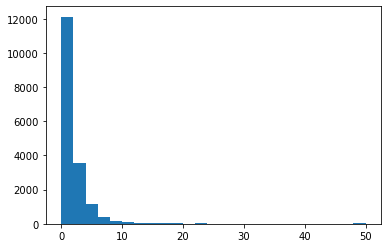

In [47]:
plt.hist(comix_cnt['contacts_trunc50'], bins=np.arange(0,52,2))
plt.show()

## compute 4x4 matrix

In [48]:
res = comix_cnt.groupby(['age_part_4cat', 'cnt_age_group_4cat'])['contacts_trunc50'].mean().reset_index()

res

,age_part_4cat,cnt_age_group_4cat,contacts_trunc50
0,0-14,0-14,5.542891
1,0-14,15-24,0.475911
2,0-14,25-64,2.796710
3,0-14,65+,0.470035
4,15-24,0-14,0.818428
5,15-24,15-24,3.000000
6,15-24,25-64,3.810298
7,15-24,65+,1.428184
8,25-64,0-14,1.074682
9,25-64,15-24,0.645055


In [49]:
matrix = res.pivot(index='age_part_4cat', columns='cnt_age_group_4cat', values='contacts_trunc50').astype(float)

matrix

cnt_age_group_4cat,0-14,15-24,25-64,65+
age_part_4cat,,,,
0-14,5.542891,0.475911,2.796710,0.470035
15-24,0.818428,3.000000,3.810298,1.428184
25-64,1.074682,0.645055,3.739023,1.018055
65+,0.326708,0.167702,1.786335,1.467081


## correct by weekday/weekend (not a big difference in the distribution -- skip)

In [50]:
### distribution are not that different
comix.groupby('weekend').size().values/comix.groupby('weekend').size().sum(), (5/7, 2/7)

(array([0.72277006, 0.27722994]), (0.7142857142857143, 0.2857142857142857))

In [51]:
comix

,panel_wave_id,age_part_4cat,sep3_quartile,education_level3,weekend
0,A1_101560,15-24,high SEP,low edu,0
1,A1_101561,25-64,high SEP,high edu,0
2,A1_101562,65+,low SEP,low edu,0
3,A1_101563,65+,low SEP,low edu,0
4,A1_101564,25-64,low SEP,low edu,0
...,...,...,...,...,...
4457,E1_907692,0-14,low SEP,low edu,1
4458,E1_907693,0-14,high SEP,low edu,1
4459,E1_907694,0-14,low SEP,low edu,1
4460,E1_907695,0-14,high SEP,low edu,1


## correct by reciprocity

In [52]:
matrix_rec = matrix.copy()

for i in ['0-14', '15-24', '25-64', '65+']:
    for j in ['0-14', '15-24', '25-64', '65+']:
        matrix_rec.loc[i,j] = (matrix.loc[i,j]*pop_age[i]+
                                    matrix.loc[j,i]*pop_age[j])/(2*pop_age[i])

In [53]:
matrix

cnt_age_group_4cat,0-14,15-24,25-64,65+
age_part_4cat,,,,
0-14,5.542891,0.475911,2.796710,0.470035
15-24,0.818428,3.000000,3.810298,1.428184
25-64,1.074682,0.645055,3.739023,1.018055
65+,0.326708,0.167702,1.786335,1.467081


In [54]:
matrix_rec

cnt_age_group_4cat,0-14,15-24,25-64,65+
age_part_4cat,,,,
0-14,5.542891,0.514395,3.383834,0.443207
15-24,0.761460,3.000000,3.669290,0.872285
25-64,0.915785,0.670835,3.739023,0.817096
65+,0.347758,0.462358,2.368968,1.467081


## save matrix

In [55]:
matrix_rec.to_csv("./../output/matrices/matrix_rec.csv")

# intermediate matrix

## compute mean per participant for each socio-demographic group

In [56]:
comix_cnt

,panel_wave_id,age_part_4cat,sep3_quartile,education_level3,weekend,cnt_age_group_4cat,contacts,contacts_trunc50
0,A1_101560,15-24,high SEP,low edu,0,0-14,0,0
1,A1_101560,15-24,high SEP,low edu,0,15-24,0,0
2,A1_101560,15-24,high SEP,low edu,0,25-64,0,0
3,A1_101560,15-24,high SEP,low edu,0,65+,0,0
4,A1_101561,25-64,high SEP,high edu,0,0-14,1,1
...,...,...,...,...,...,...,...,...
17843,E1_907695,0-14,high SEP,low edu,1,65+,0,0
17844,E1_907696,0-14,high SEP,low edu,1,0-14,4,4
17845,E1_907696,0-14,high SEP,low edu,1,25-64,2,2
17846,E1_907696,0-14,high SEP,low edu,1,15-24,0,0


In [57]:
comix_cnt_by_group = comix_cnt.groupby(["age_part_4cat", 
                                        "sep3_quartile", 
                                        "education_level3", 
                                        "cnt_age_group_4cat"])['contacts_trunc50'].mean().reset_index()

In [58]:
comix_cnt_by_group['tag_index'] = comix_cnt_by_group[['age_part_4cat', 
                                                'sep3_quartile', 
                                          'education_level3']].apply(lambda x: x[0]+", "+x[1]+", "+x[2],
                                                                                axis=1)

In [59]:
comix_cnt_by_group = comix_cnt_by_group[['tag_index', 'cnt_age_group_4cat', 'contacts_trunc50']].copy()
comix_cnt_by_group

,tag_index,cnt_age_group_4cat,contacts_trunc50
0,"0-14, high SEP, low edu",0-14,5.528541
1,"0-14, high SEP, low edu",15-24,0.473573
2,"0-14, high SEP, low edu",25-64,2.797040
3,"0-14, high SEP, low edu",65+,0.441860
4,"0-14, low SEP, low edu",0-14,5.560847
5,"0-14, low SEP, low edu",15-24,0.478836
6,"0-14, low SEP, low edu",25-64,2.796296
7,"0-14, low SEP, low edu",65+,0.505291
8,"15-24, high SEP, high edu",0-14,0.254545
9,"15-24, high SEP, high edu",15-24,2.290909


## reorder the tags and check for missing values

In [60]:
list_tag = []

for age in ['0-14', '15-24', '25-64', '65+']:
    for sep in ['low SEP', 'high SEP']:
        for edu in  ['low edu', 'high edu']:
            tag = age +", "+ sep +", "+ edu
            list_tag.append(tag)
            if len(comix_cnt_by_group[comix_cnt_by_group['tag_index']==tag])==0:
                print(tag)

0-14, low SEP, high edu
0-14, high SEP, high edu


In [61]:
comix_cnt_by_group = pd.concat([comix_cnt_by_group, pd.DataFrame({'tag_index': ['0-14, low SEP, high edu', 
                                                           '0-14, low SEP, high edu', 
                                                           '0-14, low SEP, high edu', 
                                                           '0-14, low SEP, high edu'],
                                             'cnt_age_group_4cat': ['0-14', '15-24', '25-64', '65+'],
                                             'contacts_trunc50': [np.nan, np.nan, np.nan, np.nan]})], 
          ignore_index=True)

comix_cnt_by_group = pd.concat([comix_cnt_by_group, pd.DataFrame({'tag_index': ['0-14, high SEP, high edu', 
                                                           '0-14, high SEP, high edu', 
                                                           '0-14, high SEP, high edu', 
                                                           '0-14, high SEP, high edu'],
                                             'cnt_age_group_4cat': ['0-14', '15-24', '25-64', '65+'],
                                             'contacts_trunc50': [np.nan, np.nan, np.nan, np.nan]})], 
          ignore_index=True)

In [62]:
res_pivot = comix_cnt_by_group.pivot(index='tag_index', 
                                               columns='cnt_age_group_4cat', 
                                               values='contacts_trunc50')

In [63]:
res_pivot = res_pivot.loc[list_tag]

In [64]:
intermediate_matrix = res_pivot.copy()

In [65]:
intermediate_matrix

cnt_age_group_4cat,0-14,15-24,25-64,65+
tag_index,,,,
"0-14, low SEP, low edu",5.560847,0.478836,2.796296,0.505291
"0-14, low SEP, high edu",NaN,NaN,NaN,NaN
"0-14, high SEP, low edu",5.528541,0.473573,2.797040,0.441860
"0-14, high SEP, high edu",NaN,NaN,NaN,NaN
"15-24, low SEP, low edu",1.020619,3.453608,3.845361,1.360825
"15-24, low SEP, high edu",1.464286,4.321429,6.785714,4.142857
"15-24, high SEP, low edu",0.783069,2.777778,3.333333,0.989418
"15-24, high SEP, high edu",0.254545,2.290909,3.872727,1.672727
"25-64, low SEP, low edu",1.053537,0.617591,3.562141,1.055449


# adjust intermediate matrix for reciprocity

Method inspired by https://doi.org/10.1038/s41467-024-48332-y

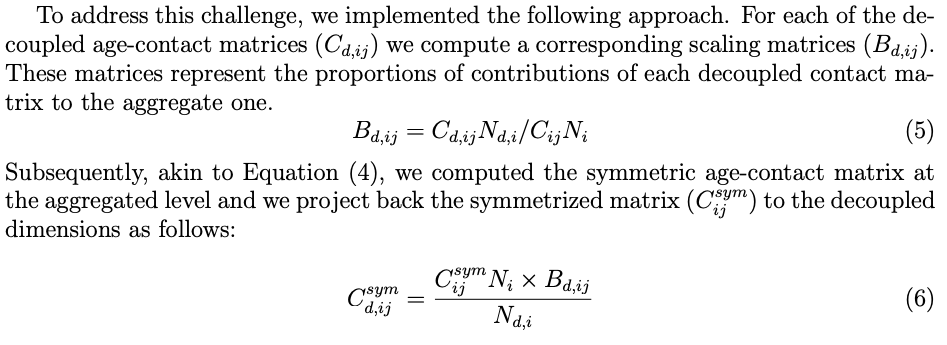

## compute scaling matrix B

In [66]:
#population, by SEP/SEP/age, and aggregated (only by age)
dict_pop_full, pop_age

({'0-14, high SEP, high edu': 0.0,
  '0-14, low SEP, high edu': 0.0,
  '0-14, high SEP, low edu': 910215.0,
  '0-14, low SEP, low edu': 413202.0,
  '15-24, high SEP, high edu': 51812.0,
  '15-24, low SEP, high edu': 24823.0,
  '15-24, high SEP, low edu': 552631.0,
  '15-24, low SEP, low edu': 264751.0,
  '25-64, high SEP, high edu': 1687317.3094791055,
  '25-64, low SEP, high edu': 536759.268093747,
  '25-64, high SEP, low edu': 1727216.6905208929,
  '25-64, low SEP, low edu': 938743.7319062528,
  '65+, high SEP, high edu': 349133.05628178443,
  '65+, low SEP, high edu': 111064.1150329906,
  '65+, high SEP, low edu': 799172.9437182155,
  '65+, low SEP, low edu': 427282.8849670094},
 {'0-14': 1323417.0,
  '15-24': 894017.0,
  '25-64': 4890036.999999998,
  '65+': 1686653.0})

In [67]:
## compute scaling matrix B 

B = intermediate_matrix.copy()

intermediate_matrix_imputed = intermediate_matrix.fillna(0)

for group in intermediate_matrix.index:
    age_i = group.split(", ")[0]
    sep_ses_i = group.split(", ")[1]+", "+group.split(", ")[2]
    for age_j in intermediate_matrix.columns:
        B.loc[group,age_j] = (intermediate_matrix_imputed.loc[group,age_j]*dict_pop_full[group])/(matrix.loc[age_i,age_j]*pop_age[age_i])

In [68]:
B

cnt_age_group_4cat,0-14,15-24,25-64,65+
tag_index,,,,
"0-14, low SEP, low edu",0.313235,0.314143,0.312177,0.335642
"0-14, low SEP, high edu",0.000000,0.000000,0.000000,0.000000
"0-14, high SEP, low edu",0.685996,0.684398,0.687858,0.646550
"0-14, high SEP, high edu",0.000000,0.000000,0.000000,0.000000
"15-24, low SEP, low edu",0.369296,0.340913,0.298862,0.282169
"15-24, low SEP, high edu",0.049677,0.039996,0.049448,0.080542
"15-24, high SEP, low edu",0.591437,0.572355,0.540766,0.428238
"15-24, high SEP, high edu",0.018025,0.044256,0.058904,0.067877
"25-64, low SEP, low edu",0.188194,0.183797,0.182889,0.199022


## adjust scaling matrix B so that weights sum to 1

In [69]:
B.iloc[:4].sum(axis=0), B.iloc[4:8].sum(axis=0), B.iloc[8:12].sum(axis=0), B.iloc[12:].sum(axis=0)

(cnt_age_group_4cat
 0-14     0.999231
 15-24    0.998541
 25-64    1.000035
 65+      0.982192
 dtype: float64,
 cnt_age_group_4cat
 0-14     1.028435
 15-24    0.997520
 25-64    0.947979
 65+      0.858827
 dtype: float64,
 cnt_age_group_4cat
 0-14     0.996812
 15-24    1.004474
 25-64    0.998190
 65+      0.992119
 dtype: float64,
 cnt_age_group_4cat
 0-14     0.826289
 15-24    0.906159
 25-64    0.963184
 65+      0.974555
 dtype: float64)

In [70]:
for age in intermediate_matrix.columns:
    
    B['adjust_factor_{}'.format(age)] = np.nan

    for k,group in enumerate(B.index):
        if k<4:
            B.loc[group, 'adjust_factor_{}'.format(age)] = 1./B.iloc[:4].sum(axis=0).loc[age]
        elif k<8:
            B.loc[group, 'adjust_factor_{}'.format(age)] = 1./B.iloc[4:8].sum(axis=0).loc[age]
        elif k<12: 
            B.loc[group, 'adjust_factor_{}'.format(age)] = 1./B.iloc[8:12].sum(axis=0).loc[age]
        else: 
            B.loc[group, 'adjust_factor_{}'.format(age)] = 1./B.iloc[12:].sum(axis=0).loc[age]

for age in intermediate_matrix.columns:
    
    B['{}_adjusted'.format(age)] = B[age]*B['adjust_factor_{}'.format(age)]

In [71]:
B

cnt_age_group_4cat,0-14,15-24,25-64,65+,adjust_factor_0-14,adjust_factor_15-24,adjust_factor_25-64,adjust_factor_65+,0-14_adjusted,15-24_adjusted,25-64_adjusted,65+_adjusted
tag_index,,,,,,,,,,,,
"0-14, low SEP, low edu",0.313235,0.314143,0.312177,0.335642,1.000770,1.001461,0.999965,1.018131,0.313476,0.314602,0.312166,0.341728
"0-14, low SEP, high edu",0.000000,0.000000,0.000000,0.000000,1.000770,1.001461,0.999965,1.018131,0.000000,0.000000,0.000000,0.000000
"0-14, high SEP, low edu",0.685996,0.684398,0.687858,0.646550,1.000770,1.001461,0.999965,1.018131,0.686524,0.685398,0.687834,0.658272
"0-14, high SEP, high edu",0.000000,0.000000,0.000000,0.000000,1.000770,1.001461,0.999965,1.018131,0.000000,0.000000,0.000000,0.000000
"15-24, low SEP, low edu",0.369296,0.340913,0.298862,0.282169,0.972351,1.002486,1.054876,1.164379,0.359085,0.341761,0.315262,0.328552
"15-24, low SEP, high edu",0.049677,0.039996,0.049448,0.080542,0.972351,1.002486,1.054876,1.164379,0.048303,0.040095,0.052161,0.093782
"15-24, high SEP, low edu",0.591437,0.572355,0.540766,0.428238,0.972351,1.002486,1.054876,1.164379,0.575085,0.573778,0.570441,0.498631
"15-24, high SEP, high edu",0.018025,0.044256,0.058904,0.067877,0.972351,1.002486,1.054876,1.164379,0.017526,0.044366,0.062136,0.079035
"25-64, low SEP, low edu",0.188194,0.183797,0.182889,0.199022,1.003199,0.995546,1.001813,1.007944,0.188796,0.182979,0.183221,0.200603


In [72]:
B.iloc[:4].sum(axis=0)[-3:], B.iloc[4:8].sum(axis=0)[-3:], B.iloc[8:12].sum(axis=0)[-3:], B.iloc[12:].sum(axis=0)[-3:]

(cnt_age_group_4cat
 15-24_adjusted    1.0
 25-64_adjusted    1.0
 65+_adjusted      1.0
 dtype: float64,
 cnt_age_group_4cat
 15-24_adjusted    1.0
 25-64_adjusted    1.0
 65+_adjusted      1.0
 dtype: float64,
 cnt_age_group_4cat
 15-24_adjusted    1.0
 25-64_adjusted    1.0
 65+_adjusted      1.0
 dtype: float64,
 cnt_age_group_4cat
 15-24_adjusted    1.0
 25-64_adjusted    1.0
 65+_adjusted      1.0
 dtype: float64)

## compute intermediate matrix by projecting the reciprocal age-stratified matrix using the scaling matrix B

In [73]:
intermediate_matrix_rec = intermediate_matrix.copy()

for group in intermediate_matrix_rec.index:
    
    if dict_pop_full[group]!= 0:
        
        age_i = group.split(", ")[0]
        sep_ses_i = group.split(", ")[1]+", "+group.split(", ")[2]

        for age_j in intermediate_matrix_rec.columns:

            intermediate_matrix_rec.loc[group,age_j]=matrix_rec.loc[age_i,age_j]*pop_age[age_i]*B.loc[group,age_j+'_adjusted']/dict_pop_full[group]

In [74]:
intermediate_matrix_rec

cnt_age_group_4cat,0-14,15-24,25-64,65+
tag_index,,,,
"0-14, low SEP, low edu",5.565127,0.518313,3.383215,0.485089
"0-14, low SEP, high edu",NaN,NaN,NaN,NaN
"0-14, high SEP, low edu",5.532796,0.512616,3.384115,0.424194
"0-14, high SEP, high edu",NaN,NaN,NaN,NaN
"15-24, low SEP, low edu",0.923322,3.462194,3.906265,0.967767
"15-24, low SEP, high edu",1.324694,4.332172,6.893188,2.946244
"15-24, high SEP, low edu",0.708418,2.784684,3.386128,0.703637
"15-24, high SEP, high edu",0.230279,2.296604,3.934065,1.189580
"25-64, low SEP, low edu",0.900639,0.639412,3.568599,0.853838


In [75]:
# this matrix is built so that, if we aggregate on SEP and SES, we obtain the correct reciprocal 3x3 matrix
## let's check that

## check reciprocity

In [76]:
## to aggregate on rows, we have to compute a weighted average of the number of contacts accross the subgroups

matrix_rec_check = matrix_rec.copy()

for age_i in matrix_rec.index:
    
    for age_j in matrix_rec.index:
        s=0
        
        for sep in ['low SEP', 'high SEP']:
            for edu in ['low edu', 'high edu']:
                tag = age_i+', '+sep+', '+edu
                if intermediate_matrix_rec.loc[tag, age_j]>0:
                    s +=intermediate_matrix_rec.loc[tag, age_j]*dict_pop_full[tag]
                
        matrix_rec_check.loc[age_i, age_j] = s/pop_age[age_i]
        
matrix_rec_check

cnt_age_group_4cat,0-14,15-24,25-64,65+
age_part_4cat,,,,
0-14,5.542891,0.514395,3.383834,0.443207
15-24,0.761460,3.000000,3.669290,0.872285
25-64,0.915785,0.670835,3.739023,0.817096
65+,0.347758,0.462358,2.368968,1.467081


In [77]:
matrix_rec_check-matrix_rec

cnt_age_group_4cat,0-14,15-24,25-64,65+
age_part_4cat,,,,
0-14,8.881784e-16,0.0,0.000000e+00,0.0
15-24,0.000000e+00,0.0,0.000000e+00,0.0
25-64,-2.220446e-16,0.0,-4.440892e-16,0.0
65+,0.000000e+00,0.0,-4.440892e-16,0.0


## save matrix

In [78]:
intermediate_matrix_rec.to_csv("./../output/matrices/intermediate_matrix_rec.csv")